In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch 
from functools import reduce
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Data Prep

- Load all the source data
- Drop columns not required
- Data type consistency 
- Add derived features
- Aggregate data 

In [30]:
# DATA_PATH='/data/workspace_files/iqvia_data/'
DATA_PATH='/Users/a206602774/Downloads/OneDrive_1_4-14-2021/'


files_claims = ['claims_2015.dat','claims_2016.dat', 'claims_2017.dat', 'claims_2018.dat', 'claims_2019.dat']
files_lookup = {
    'enroll':{'file':'enroll_synth.dat', 'key':'pat_id'},
    'enroll2':{'file':'enroll2.dat', 'key':'pat_id'},
    'dx_lookup':{'file':'pp_dx_lookup.dat', 'key':'dx_cd'},
    'pos_lookup':{'file':'pp_pos_lookup.dat', 'key':'place_of_svc_cd'},
    'pr_lookup':{'file':'pp_pr_lookup.dat', 'key':'procedure_cd'},
    'rev_lookup':{'file':'pp_rev_lookup.dat', 'key':'rev_cd'},
    'rx_lookup':{'file':'pp_rx_lookup.dat', 'key':'ndc'}}

selected_columns = ['pat_id', 'rectype', 'pos', 'conf_num', 'ndc', 'formulary', 'quan', 'proc_cde'
                   , 'from_dt', 'to_dt', 'diag_admit', 'diag1', 'diag2', 'diag3', 'icdprc1'
                   , 'icdprc2', 'icdprc3', 'paid', 'copay', 'dispense_fee', 'bill_spec'
                   , 'prscbr_spec', 'pmt_st_cd', 'paid_dt']

group_by_columns = ['pat_id', 'from_dt', 'to_dt', 'rectype', 'conf_num', 'icdprc1'
                    ,'diag_admit', 'diag1', 'proc_cde', 'bill_spec', 'pos', 'ndc', 'quan'
                    ,'formulary', 'paid_dt', 'pmt_st_cd']

date_columns = ['from_dt', 'to_dt', 'paid_dt']
char_columns = ['pat_id', 'rectype', 'conf_num', 'icdprc1', 'diag_admit', 'diag1'
                , 'proc_cde', 'bill_spec', 'pos', 'ndc', 'formulary', 'pmt_st_cd']

cat_features = ['rectype', 'icdprc1', 'diag_admit', 'diag1', 'proc_cde', 'bill_spec', 'pos', 'ndc', 'formulary']
numerical_columns = ['quan', 'paid', 'copay', 'dispense_fee']
target_columns = ['paid', 'copay', 'dispense_fee']

e_selected_columns = ['der_sex', 'der_yob', 'pat_id', 'pat_state']
e2_selected_columns = ['pat_id', 'mh_cd']





claims_dtype = {}
for column in selected_columns:
    if column in date_columns:
        claims_dtype[column] = 'object'
    elif column in numerical_columns:
        claims_dtype[column] = 'float64'
    else:
        claims_dtype[column] = 'str'


In [23]:
def custom_fill_na(df):
    for col in df:
        #get dtype for column
        dt = df[col].dtype 
        #check if it is a number
        if dt == int or dt == float:
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna("", inplace=True)
        
def load_data(files):
    # Load Claims_15 data (revisit later)
    data = pd.DataFrame()
    for file in files:
        print(file)
        data = data.append(pd.read_table(DATA_PATH+file, delimiter="|"
                                         , usecols = selected_columns
                                         , dtype = claims_dtype)) 
    custom_fill_na(data)        
    # Create aggregate dataset for training
    data = data.groupby(group_by_columns).sum().reset_index()
    # Data type cleanup and calculate derived columns     
    for column in date_columns: 
        data[column] = pd.to_datetime(data[column])

    return data

In [24]:
combined_data = load_data(files_claims[0:2])

claims_2015.dat
claims_2016.dat


# Cleansing & Enrichment

In [25]:
dx_lookup = pd.read_table(DATA_PATH+files_lookup['dx_lookup']['file'],delimiter="|")
pos_lookup = pd.read_table(DATA_PATH+files_lookup['pos_lookup']['file'],delimiter="|")
pr_lookup = pd.read_table(DATA_PATH+files_lookup['pr_lookup']['file'],delimiter="|")
rev_lookup = pd.read_table(DATA_PATH+files_lookup['rev_lookup']['file'],delimiter="|")

''' 
We only want the values that are available in the lookup
'''
dx_key = files_lookup['dx_lookup']['key']
pos_key = files_lookup['pos_lookup']['key'] 
pr_key = files_lookup['pr_lookup']['key'] 
# rev_key = files_lookup['rev_lookup']['key'] 

combined_data = combined_data[(combined_data['diag1'].isin(dx_lookup[dx_key])) | (combined_data['diag1']=="")]
combined_data = combined_data[(combined_data['diag_admit'].isin(dx_lookup[dx_key])) | (combined_data['diag_admit']=="")]
# print(combined_data[(combined_data['pos'].isin(pos_lookup[pos_key])) | (combined_data['pos']=="")].shape)
combined_data = combined_data[(combined_data['proc_cde'].isin(pr_lookup[pr_key])) | (combined_data['proc_cde']=="")]

enroll = pd.read_table(DATA_PATH+files_lookup['enroll']['file'],delimiter="|", usecols = e_selected_columns)

data_frames = [combined_data, enroll]
combined_data = reduce(lambda  left,right: pd.merge(left,right,on=['pat_id'],how='inner'), data_frames)
# Derived columns 
combined_data['quarter'] = combined_data['to_dt'].dt.to_period("Q")
combined_data['duration'] = combined_data['to_dt'] - combined_data['from_dt']
duration_bins= [pd.Timedelta(days = 0),
                pd.Timedelta(days = 7),
                pd.Timedelta(days = 15),
                pd.Timedelta(days = 30),
                pd.Timedelta(days = 60),
                pd.Timedelta(days = 5000)]
duration_groups = ['<7', '8-15', '16-30', '31-60', '60>']
combined_data['duration'] = pd.cut(combined_data['duration'], bins=duration_bins, labels=duration_groups, right=False)


combined_data['pat_age'] = combined_data['to_dt'].dt.year - combined_data['der_yob']
pat_age_bins= [0,10,20,30,40,50,60,70,80,150]
pat_age_groups = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81 >']
combined_data['age_group'] = pd.cut(combined_data['pat_age'], bins=pat_age_bins, labels=pat_age_groups, right=False)

combined_data

,pat_id,from_dt,to_dt,rectype,conf_num,icdprc1,diag_admit,diag1,proc_cde,bill_spec,...,paid,copay,dispense_fee,der_sex,der_yob,pat_state,quarter,duration,pat_age,age_group
0,0309AAAAAAAABEUP,2015-01-02,2015-01-02,M,,,,7391,98941,CHIRO,...,0.00,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20
1,0309AAAAAAAABEUP,2015-01-05,2015-01-05,M,,,,7391,98941,CHIRO,...,0.00,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20
2,0309AAAAAAAABEUP,2015-01-20,2015-01-20,M,,,,4770,95117,ALLERGY,...,0.00,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20
3,0309AAAAAAAABEUP,2015-02-10,2015-02-10,M,,,,4770,95117,ALLERGY,...,0.00,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20
4,0309AAAAAAAABEUP,2015-03-03,2015-03-03,M,,,,4770,95117,ALLERGY,...,0.00,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385435,s153AAAAAQWAQSGZ,2016-12-28,2016-12-28,S,,,,S8331XA,20610,GP_FP,...,181.22,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60
1385436,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,7.00,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60
1385437,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,13.42,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60
1385438,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,P,,,,,,,...,3.79,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60


In [28]:
duration_bins= [pd.Timedelta(days = 0),
                pd.Timedelta(days = 7),
                pd.Timedelta(days = 15),
                pd.Timedelta(days = 30),
                pd.Timedelta(days = 60),
                pd.Timedelta(days = 5000)]
duration_groups = ['<7', '8-15', '16-30', '31-60', '60>']
combined_data['duration'] = pd.cut(combined_data['duration'], bins=duration_bins, labels=duration_groups, right=False)


In [27]:
combined_data

,pat_id,from_dt,to_dt,rectype,conf_num,icdprc1,diag_admit,diag1,proc_cde,bill_spec,...,copay,dispense_fee,der_sex,der_yob,pat_state,quarter,duration,pat_age,age_group,duration_group
0,0309AAAAAAAABEUP,2015-01-02,2015-01-02,M,,,,7391,98941,CHIRO,...,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20,<7
1,0309AAAAAAAABEUP,2015-01-05,2015-01-05,M,,,,7391,98941,CHIRO,...,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20,<7
2,0309AAAAAAAABEUP,2015-01-20,2015-01-20,M,,,,4770,95117,ALLERGY,...,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20,<7
3,0309AAAAAAAABEUP,2015-02-10,2015-02-10,M,,,,4770,95117,ALLERGY,...,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20,<7
4,0309AAAAAAAABEUP,2015-03-03,2015-03-03,M,,,,4770,95117,ALLERGY,...,0.0,0.0,F,1996.0,MN,2015Q1,0 days,19.0,11-20,<7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385435,s153AAAAAQWAQSGZ,2016-12-28,2016-12-28,S,,,,S8331XA,20610,GP_FP,...,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60,<7
1385436,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60,<7
1385437,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60,<7
1385438,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,P,,,,,,,...,0.0,0.0,M,1963.0,WA,2016Q4,0 days,53.0,51-60,<7


In [87]:
train

,pat_id,from_dt,to_dt,rectype,conf_num,icdprc1,diag_admit,diag1,proc_cde,bill_spec,...,paid_dt,pmt_st_cd,paid,copay,dispense_fee,der_sex,der_yob,pat_state,duration,pat_age
0,0309AAAAAAAABEUP,2015-01-02,2015-01-02,M,,,,7391,98941,CHIRO,...,2015-02-01,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
1,0309AAAAAAAABEUP,2015-01-05,2015-01-05,M,,,,7391,98941,CHIRO,...,2015-02-04,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
2,0309AAAAAAAABEUP,2015-01-20,2015-01-20,M,,,,4770,95117,ALLERGY,...,2015-02-19,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
3,0309AAAAAAAABEUP,2015-02-10,2015-02-10,M,,,,4770,95117,ALLERGY,...,2015-03-12,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
4,0309AAAAAAAABEUP,2015-03-03,2015-03-03,M,,,,4770,95117,ALLERGY,...,2015-04-02,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401657,s153AAAAAQWAQSGZ,2016-12-28,2016-12-28,S,,,,S8331XA,20610,GP_FP,...,2017-01-27,P,181.22,0.0,0.0,M,1963.0,WA,0 days,53.0
1401658,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,2017-01-03,P,7.00,0.0,0.0,M,1963.0,WA,0 days,53.0
1401659,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,2017-01-03,P,13.42,0.0,0.0,M,1963.0,WA,0 days,53.0
1401660,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,P,,,,,,,...,2017-01-03,P,3.79,0.0,0.0,M,1963.0,WA,0 days,53.0


In [65]:
rx_lookup = pd.read_table(DATA_PATH+files_lookup['rx_lookup']['file'],delimiter="|", usecols=['ndc'],error_bad_lines=False)

ParserError: Error tokenizing data. C error: EOF inside string starting at row 87646

In [32]:
train = load_data()

claims_2015.dat
claims_2016.dat


In [34]:
train

,pat_id,from_dt,to_dt,rectype,conf_num,icdprc1,diag_admit,diag1,proc_cde,bill_spec,...,paid_dt,pmt_st_cd,paid,copay,dispense_fee,der_sex,der_yob,pat_state,duration,pat_age
0,0309AAAAAAAABEUP,2015-01-02,2015-01-02,M,,,,7391,98941,CHIRO,...,2015-02-01,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
1,0309AAAAAAAABEUP,2015-01-05,2015-01-05,M,,,,7391,98941,CHIRO,...,2015-02-04,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
2,0309AAAAAAAABEUP,2015-01-20,2015-01-20,M,,,,4770,95117,ALLERGY,...,2015-02-19,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
3,0309AAAAAAAABEUP,2015-02-10,2015-02-10,M,,,,4770,95117,ALLERGY,...,2015-03-12,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
4,0309AAAAAAAABEUP,2015-03-03,2015-03-03,M,,,,4770,95117,ALLERGY,...,2015-04-02,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401657,s153AAAAAQWAQSGZ,2016-12-28,2016-12-28,S,,,,S8331XA,20610,GP_FP,...,2017-01-27,P,181.22,0.0,0.0,M,1963.0,WA,0 days,53.0
1401658,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,2017-01-03,P,7.00,0.0,0.0,M,1963.0,WA,0 days,53.0
1401659,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,,,,,,,,...,2017-01-03,P,13.42,0.0,0.0,M,1963.0,WA,0 days,53.0
1401660,s153AAAAAQWAQSGZ,2016-12-29,2016-12-29,P,,,,,,,...,2017-01-03,P,3.79,0.0,0.0,M,1963.0,WA,0 days,53.0


In [10]:
# enroll2 = pd.read_table(DATA_PATH+"enroll2.dat",delimiter="|", usecols = e2_selected_columns)
# enroll2

In [130]:
train.pat_age


train['AgeGroup'] = pd.cut(train['pat_age'], bins=bins, labels=labels, right=False)
train['AgeGroup']



0         11-20
1         11-20
2         11-20
3         11-20
4         11-20
          ...  
647078    31-40
647079    31-40
647080    31-40
647081    31-40
647082    31-40
Name: AgeGroup, Length: 647083, dtype: category
Categories (9, object): ['0-10' < '11-20' < '21-30' < '31-40' ... '51-60' < '61-70' < '71-80' < '81 >']

In [12]:
train[numerical_columns].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647083 entries, 0 to 647082
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   quan          647083 non-null  float64
 1   paid          647083 non-null  float64
 2   copay         647083 non-null  float64
 3   dispense_fee  647083 non-null  float64
dtypes: float64(4)
memory usage: 24.7 MB


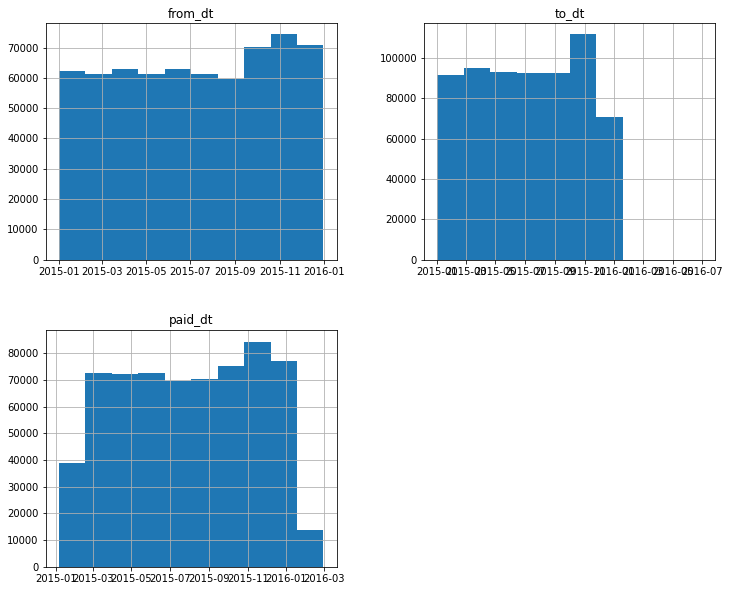

In [146]:
train[date_columns].hist(figsize=(12,10))
plt.show()

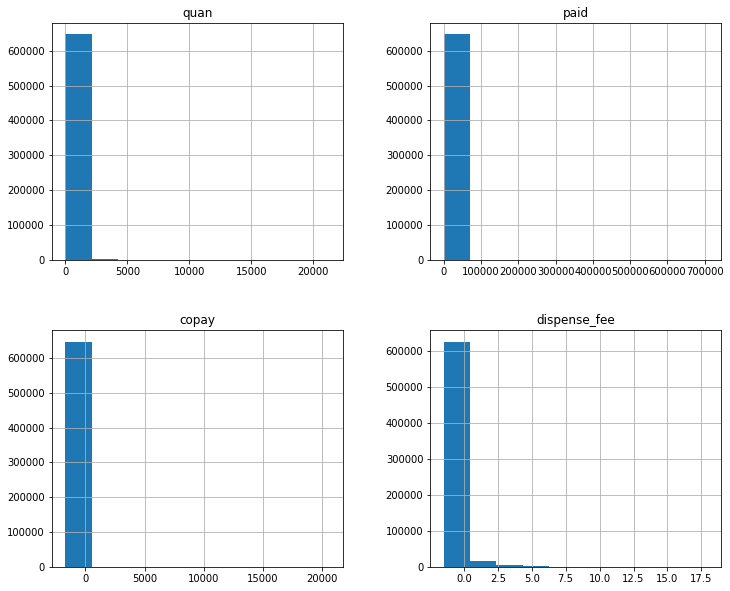

In [149]:
train[numerical_columns].hist(figsize=(12,10))
plt.show()

In [108]:
train.to_dt

0        2015-01-02
1        2015-01-05
2        2015-01-20
3        2015-02-10
4        2015-03-03
            ...    
647078   2015-11-06
647079   2015-11-06
647080   2015-11-06
647081   2015-11-06
647082   2015-11-06
Name: to_dt, Length: 647083, dtype: datetime64[ns]

In [37]:
train.diag1.unique().shape

(9767,)

In [107]:
days_bet_paid_to = train['to_dt'] - train['paid_dt']
days_bet_paid_to.sort_values(ascending=False)

164760   334 days
151481   334 days
158986   334 days
153052   334 days
161462   334 days
           ...   
434821   -60 days
81753    -60 days
237362   -60 days
81752    -60 days
330043   -60 days
Length: 647083, dtype: timedelta64[ns]

# One Hot Encoding of Categorical features

In [ ]:
# Pandas get_dummies

In [26]:
unique_rectype = train.rectype.unique()

In [43]:
dummies = pd.get_dummies(train['rectype'], prefix='rectype')
type(dummies), dummies.shape

(pandas.core.frame.DataFrame, (647083, 6))

In [61]:
# Using scikit label encoder 

# Apply LabelEncoder - Encodes the given data into 1 to n-1 integers
labelencoder = LabelEncoder()
print(unique_rectype)
integer_encoding = labelencoder.fit(unique_rectype)
print(integer_encoding)
integer_encoding = integer_encoding.transform(train.rectype)
print(integer_encoding)

# Apply OneHotEncoder - Encodes the given data with integer values and applies one hot encoding 
one_hot_encoding = OneHotEncoder(sparse=False)
one_encoded = one_hot_encoding.fit_transform(integer_encoding.reshape(len(integer_encoding), 1))


# Inverse transform helps to get back the original values 
inv_integer = one_hot_encoding.inverse_transform(one_encoded)
inv_label = labelencoder.inverse_transform(inv_integer.reshape(len(inv_integer), ))

integer_encoding.shape, one_encoded.shape, inv_integer.shape, inv_label.shape

['M' 'A' 'P' 'S' 'F' '']
LabelEncoder()
[3 3 3 ... 1 1 1]


((647083,), (647083, 6), numpy.ndarray, (647083, 1), (647083,))

In [ ]:
one_encoded = one_hot_encoding.fit_transform(integer_encoding.reshape(len(integer_encoding), 1))

In [42]:
train.shape

(1401662, 24)

In [35]:
# Lookups 
# enroll = pd.read_table(DATA_PATH+"enroll_synth.dat",delimiter="|")
# enroll = pd.read_table(DATA_PATH+"enroll_synth.dat",delimiter="|")
dx_lookup = pd.read_table(DATA_PATH+"pp_dx_lookup.dat",delimiter="|", usecols = ['dx_cd'])

# 

((1392518, 24), (1401662, 24))

In [49]:
dx_lookup

,dx_cd
0,7889
1,78053
2,70710
3,78902
4,2948
...,...
95196,V8052
95197,T505X2S
95198,B171
95199,T50Z16S


In [74]:
# dx_int_encoding = labelencoder.fit(dx_lookup.dx_cd)
# dx_int_encoding = dx_int_encoding.transform(train.diag1)
missing = []
for code in train.diag1.unique():
    if code not in dx_lookup.dx_cd.unique():
        missing.append(code)

In [113]:
dx_lookup.dropna(inplace=True)

In [114]:
missing

['',
 'XXX',
 'O359X',
 'T888X',
 'S134X',
 'W57XX',
 'T814X',
 'S335X',
 'S025X',
 'S233X',
 'T185X',
 'O351X',
 'S139X',
 'O321X',
 'O328X',
 '32',
 'DEP',
 'CMF',
 'NB',
 'DIAG',
 'S0501X',
 '78098',
 '49190',
 '41661',
 'S020X',
 'UNK',
 'S8011X',
 '99999']

In [100]:
# df1[~df1.isin(df2)].dropna()

common = train.merge(dx_lookup,left_on="diag1", right_on="dx_cd")
result = train[~train.diag1.isin(common.dx_cd)]
len(result.diag1.unique())



# df1[~df1.isin(df2)].dropna()

common = dx_lookup.merge(train,left_on="dx_cd", right_on="diag1")
result = dx_lookup[~dx_lookup.dx_cd.isin(common.diag1)]
len(result.dx_cd.unique())

84730

# Play area

In [184]:
claims_15[claims_15['pat_id']=='a775AAAAAAFIVMHE'].sort_values('from_dt')

,pat_id,rectype,pos,conf_num,ndc,formulary,quan,proc_cde,from_dt,to_dt,diag_admit,diag1,diag2,diag3,icdprc1,icdprc2,icdprc3,paid,copay,dispense_fee,bill_spec,prscbr_spec,pmt_st_cd,paid_dt
253453,a775AAAAAAFIVMHE,P,01,0.0,5.550874e+08,0,30.0,0,2015-01-06,2015-01-06,0,0,0,0,0,0,0,6.35,0.0,0.0,0,INTERN,P,2015-01-11
262893,a775AAAAAAFIVMHE,A,23,0.0,0.000000e+00,0,0.0,94760,2015-01-09,2015-01-09,0,95901,0,0,0,0,0,0.00,0.0,0.0,INTERN,0,P,2015-02-08
228244,a775AAAAAAFIVMHE,A,23,0.0,0.000000e+00,0,0.0,70450,2015-01-09,2015-01-09,0,95901,0,0,0,0,0,0.00,0.0,0.0,RADIOL,0,P,2015-02-08
235185,a775AAAAAAFIVMHE,M,23,0.0,0.000000e+00,0,0.0,99284,2015-01-09,2015-01-09,0,95901,E9179,0,0,0,0,67.67,0.0,0.0,ER_PHYS,0,P,2015-02-08
235220,a775AAAAAAFIVMHE,A,23,0.0,0.000000e+00,0,0.0,70450,2015-01-09,2015-01-09,0,95901,0,0,0,0,0,196.84,0.0,0.0,RADIOL,0,P,2015-02-08
256453,a775AAAAAAFIVMHE,M,11,0.0,0.000000e+00,0,0.0,99214,2015-01-09,2015-01-09,0,25000,4011,2724,0,0,0,112.81,0.0,0.0,OSTOPATH,0,P,2015-02-08
253253,a775AAAAAAFIVMHE,A,23,0.0,0.000000e+00,0,0.0,70450,2015-01-09,2015-01-09,0,95901,0,0,0,0,0,58.46,0.0,0.0,RADIOL,0,P,2015-02-08
253042,a775AAAAAAFIVMHE,A,23,0.0,0.000000e+00,0,0.0,70450,2015-01-09,2015-01-09,0,95901,0,0,0,0,0,197.64,0.0,0.0,HOSPITAL,0,P,2015-02-08
235564,a775AAAAAAFIVMHE,M,23,0.0,0.000000e+00,0,0.0,0,2015-01-09,2015-01-09,0,95901,0,0,0,0,0,49.60,0.0,0.0,INTERN,0,P,2015-02-08
237508,a775AAAAAAFIVMHE,M,23,0.0,0.000000e+00,0,0.0,0,2015-01-09,2015-01-09,0,95901,0,0,0,0,0,49.60,0.0,0.0,HOSPITAL,0,P,2015-02-08


<AxesSubplot:xlabel='paid_dt'>

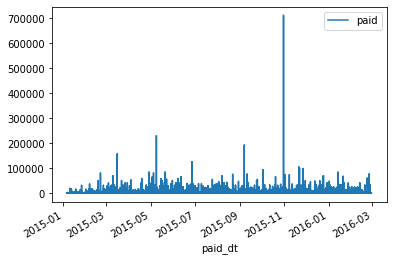

In [268]:
agg_model_input.plot(x='paid_dt',y='paid')

In [256]:
def plot_histogram(x):
    plt.hist(x, color='gray', alpha=0.5)
    plt.title("histgram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

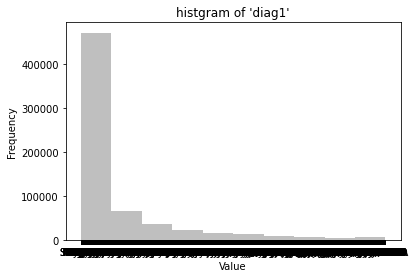

In [260]:
plot_histogram(agg_model_input['diag1'].astype(str))